# Aligning Deep Exposures of Sparse Fields 

<div class="alert alert-block alert-warning" style="color:black" > <b> This notebook requires creating and activating a virtual environment using the requirements file in this notebook's repository. Please also review the README file before using the notebook.</b> <br> </div>

<a id="toc"></a>
## Table of Contents

[Introduction](#intro) <br>

[1. Download the Observations with `astroquery`](#download) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Check image header data](#check_keywords) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Inspect the alignment](#check_wcs) <br>

[2. Align with `TweakReg`](#tweakreg) <br>

&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Use 'default' parameters (Test1)](#test1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Adjust conv_width to find extended objects (Test 2)](#test2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Exclude flagged pixels with `dqbits` (Test 3)](#test3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Overplot Matched Sources on the Image](#overplot) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Rerun TweakReg to update the header WCS](#updatehdr) <br>

[3. Combine the Images using `AstroDrizzle`](#adriz) <br>

[4. Inspect the drizzled science and weight images](#display) <br>

The following Python packages are required to run the Jupyter Notebook:
 - [**collections**](https://docs.python.org/3/library/collections.html) - include specialized datatypes
 - [**glob**](https://docs.python.org/3/library/glob.html) - gather lists of filenames
 - [**os**](https://docs.python.org/3/library/os.html) - change and make directories 
 - [**shutil**](https://docs.python.org/3/library/shutil.html) - perform high-level file operations
 - [**iPython**](https://ipython.readthedocs.io/en/stable/) - interactive handling
 - [**matplotlib**](https://matplotlib.org) - create graphics
 - [**numpy**](https://numpy.org) - math and array functions
 - [**astropy**](https://www.astropy.org) - FITS file handling and related operations
 - [**astroquery**](https://astroquery.readthedocs.io/en/latest/) - download data and query databases
 - [**drizzlepac**](https://drizzlepac.readthedocs.io/en/latest/) - align and combine HST images

## Introduction <a id="intro"></a>
[Table of Contents](#toc)

This notebook demonstrates aligning long exposures which have relatively few stars and a large number of cosmic rays. It is based on the example described in the ISR linked here ([ACS ISR 2015-04: Basic Use of SExtractor Catalogs With TweakReg - I](https://ui.adsabs.harvard.edu/abs/2015acs..rept....4L/abstract)), but uses a much simpler methodology.

Rather than making use of external software (e.g. [SExtractor](http://www.astromatic.net/software/sextractor)) and going through the extra steps to create 'cosmic-ray cleaned' images for each visit, this notebook demonstrates new features in `TweakReg` designed to mitigate false detections.

`TweakReg`’s source finding task `imagefind` includes parameters to exclude false detections and allows the software to more easily solve for the image offsets using matched sources lists. For example, `dqbits` is a list of DQ flag values to include as 'good' or to exclude as 'bad' before generating and matching source lists. For ACS/WFC, setting `dqbits=-16` will mask hot pixels flagged by the instrument team, eliminating a common problem where `TweakReg` locks onto hot pixels and solves for the dither pattern. This can occur when users set the detection threshold value too low and hot pixels outnumber astronomical sources. Other new parameters allow selection for sharpness and roundness, which give users better control over source selection criteria and the mitigation of artifacts. More details on imagefindpars options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/latest/user_reprocessing/imagefindpars.html).

Please also make sure to appropriately set your environment variables to allow Python to locate the appropriate reference files.

In [1]:
import glob
import os
import shutil

from collections import defaultdict
from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import ascii, fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval

from astroquery.mast import Observations

from drizzlepac import tweakreg, astrodrizzle

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Improves the resolution of figures rendered in notebooks.

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


Along with the above imports, we also set up the required local reference files.

In [2]:
# Set the locations of reference files to your local computer.
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'
os.environ['jref'] = './crds_cache/references/hst/acs/'

## 1. Download the Observations with `astroquery` <a id="download"></a>
[Table of Contents](#toc)

---
MAST queries may be done using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#observation-criteria-queries"> `query_criteria`</a>, where we specify: <br>

&nbsp;&nbsp;&nbsp;&nbsp;--> obs_id, proposal_id, and filters 

MAST data products may be downloaded by using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data"> `download_products`</a>, where we specify:<br> 

&nbsp;&nbsp;&nbsp;&nbsp;--> products = calibrated (FLT, FLC) or drizzled (DRZ, DRC) files

&nbsp;&nbsp;&nbsp;&nbsp;--> type = standard products (CALxxx) or advanced products (HAP-SVM)
____
The data in this example are comprised of 4 exposures in the F814W filter, all from Visit 0X of HST program 10092. Each exposure was dithered by ~60 pixels along the y-axis in order to obtain coverage in the area of the CCD chip gap. The X and Y dithers are given in arcseconds by the `POSTARG1` and `POSTARG2` keywords recorded in the image header.

The following commands query MAST, download the calibrated, CTE-corrected FLC files, and place them in the same 'working' directory as this notebook. 

                j8xi0xs0q_flc.fits
                j8xi0xs3q_flc.fits
                j8xi0xs6q_flc.fits
                j8xi0xsaq_flc.fits
<div class="alert alert-block alert-warning" style="color:black" >  Depending on your connection speed, this cell may take a few minutes to execute. </div>

In [3]:
obs_ids = ["j8xi0x*"]
props = ["10092"]
filts = ["F814W"]

obsTable = Observations.query_criteria(obs_id=obs_ids, proposal_id=props, filters=filts)
products = Observations.get_product_list(obsTable)

data_prod = ["FLC"]  # ['FLC','FLT','DRC','DRZ']
data_type = ["CALACS"]  # ['CALACS','CALWF3','CALWP2','HAP-SVM']

Observations.download_products(
    products, productSubGroupDescription=data_prod, project=data_type, cache=True
)

 [Done]


 [Done]


 [Done]


 [Done]


<Table length=4>
                   Local Path                    Status  Message  URL  
                     str47                        str8    object object
----------------------------------------------- -------- ------- ------
./mastDownload/HST/j8xi0xs0q/j8xi0xs0q_flc.fits COMPLETE    None   None
./mastDownload/HST/j8xi0xs3q/j8xi0xs3q_flc.fits COMPLETE    None   None
./mastDownload/HST/j8xi0xs6q/j8xi0xs6q_flc.fits COMPLETE    None   None
./mastDownload/HST/j8xi0xsaq/j8xi0xsaq_flc.fits COMPLETE    None   None

In [4]:
# Move the files to the local working directory
for flc in glob.glob("./mastDownload/HST/*/*flc.fits"):
    flc_name = os.path.basename(flc)
    os.rename(flc, flc_name)
if os.path.exists("mastDownload"):
    shutil.rmtree("mastDownload")

### 1.1 Check image header data <a id="check_keywords"></a>

Here we will look at important keywords in the image headers.

In [5]:
input_files = sorted(glob.glob("*flc.fits"))
data = []
keywords_ext0 = [
    "ROOTNAME",
    "ASN_ID",
    "TARGNAME",
    "DETECTOR",
    "FILTER2",
    "exptime",
    "ra_targ",
    "dec_targ",
    "postarg1",
    "postarg2",
    "DATE-OBS",
]
keywords_ext1 = ["orientat"]

for path in input_files:
    path_data = []
    for keyword in keywords_ext0:
        path_data.append(fits.getval(path, keyword, ext=0))
    for keyword in keywords_ext1:
        path_data.append(fits.getval(path, keyword, ext=1))
    data.append(path_data)

keywords = keywords_ext0 + keywords_ext1
table = Table(
    np.array(data),
    names=keywords,
    dtype=[
        "str",
        "str",
        "str",
        "str",
        "str",
        "f8",
        "f8",
        "f8",
        "f8",
        "f8",
        "str",
        "f8",
    ],
)
table["exptime"].format = "7.1f"
table["ra_targ"].format = table["dec_targ"].format = "7.4f"
table["postarg1"].format = table["postarg2"].format = "7.3f"
table["orientat"].format = "7.2f"
table

<Table length=4>
 ROOTNAME   ASN_ID    TARGNAME  DETECTOR ... postarg2  DATE-OBS  orientat
  str32     str32      str32     str32   ... float64    str32    float64 
--------- --------- ----------- -------- ... -------- ---------- --------
j8xi0xs0q J8XI0X010 COSMOS23-14      WFC ...   -3.052 2004-05-15    97.75
j8xi0xs3q J8XI0X010 COSMOS23-14      WFC ...    0.024 2004-05-15    97.76
j8xi0xs6q J8XI0X010 COSMOS23-14      WFC ...    3.052 2004-05-15    97.76
j8xi0xsaq J8XI0X010 COSMOS23-14      WFC ...    6.127 2004-05-15    97.76

### 1.2 Inspect the Alignment <a id="check_wcs"></a>

Check the active WCS solution in the image header. If the image is aligned to a catalog, list the number of matches and the fit RMS in mas. <br>

Convert the fit RMS values to pixels for comparison with the alignment results performed later in this notebook.

In [6]:
ext_0_kws = ["DETECTOR", "EXPTIME"]
ext_1_kws = ["WCSNAME", "NMATCHES", "RMS_RA", "RMS_DEC"]

det_scale = {"IR": 0.1283, "UVIS": 0.0396, "WFC": 0.05}  # plate scale (arcsec/pixel)

format_dict = {}
col_dict = defaultdict(list)

for f in sorted(glob.glob("*flc.fits")):
    col_dict["filename"].append(f)
    hdr0 = fits.getheader(f, 0)
    hdr1 = fits.getheader(f, 1)

    for kw in ext_0_kws:  # extension 0 keywords
        col_dict[kw].append(hdr0[kw])
    for kw in ext_1_kws:  # extension 1 keywords
        if "RMS" in kw:
            val = np.around(hdr1[kw], 1)
        else:
            val = hdr1[kw]
        col_dict[kw].append(val)

    for kw in ["RMS_RA", "RMS_DEC"]:
        val = np.round(
            hdr1[kw] / 1000.0 / det_scale[hdr0["DETECTOR"]], 2
        )  # convert RMS from mas to pixels
        col_dict[f"{kw}_pix"].append(val)

wcstable = Table(col_dict)
wcstable

<Table length=4>
     filename      DETECTOR EXPTIME ... RMS_DEC RMS_RA_pix RMS_DEC_pix
      str18          str3   float64 ... float64  float64     float64  
------------------ -------- ------- ... ------- ---------- -----------
j8xi0xs0q_flc.fits      WFC   507.0 ...    41.9       0.77        0.84
j8xi0xs3q_flc.fits      WFC   507.0 ...    41.9       0.77        0.84
j8xi0xs6q_flc.fits      WFC   507.0 ...    41.9       0.77        0.84
j8xi0xsaq_flc.fits      WFC   507.0 ...    41.9       0.77        0.84

Here we see that the four FLC images have a "FIT_REL_GSC242" WCS solution, which means they were aligned as a set to the reference catalog 'GSC v2.4.2' using the combined drizzled image and that WCS was propogated back to the original FLCs.  This is reflected in the fact that the number of matches and fit rms values are the same for each FLC frame.

For more details on absolute astrometry in HST images, see [Section 4.5 in the DrizzlePac Handbook](https://hst-docs.stsci.edu/drizzpac/chapter-4-astrometric-information-in-the-header/4-5-absolute-astrometry).

---

## 2. Align with `TweakReg`  <a id="tweakreg"></a>
[Table of Contents](#toc)

Here we use `TweakReg` to test the relative alignment of the FLC frames based on sources in the image. 

Typically, observations taken as part of a dither pattern with small POSTARG offsets (e.g. a few pixels) will have excellent relative astrometry and will not need further tweaks to the alignment. Instead the typical workflow would be to align the combined DRC frames from different visits or filters and then run TweakBack to propogate those solutions back to the FLC frames.   This is recommended when there are not enough point sources to get an accurate FLC solution for each individual frame and ensures that any commanded dithers which carefully subsample the detector pixels are not corrupted with due to uncertainties in alignment of FLC frames.

For this dataset, however, the commanded dithers are large (up to ~120 pixels), and small pointing errors may need to be corrected between FLC frames.  

Here, we build on the existing absolute positions based on GSC v2.4.2 and then test for additional errors in the alignment between frames. 

The `TweakReg` parameter `conv_width` specifies the convolution kernel width in pixels, with recommended values ~2x the PSF FWHM for detecting point sources in the FLC frame. For ACS/WFC & WFC3/UVIS, this parameter is typically set to 3.5 pixels and for WFC3/IR to 2.5 pixels, but the value can be increased in order to use compact objects such as small galaxies for alignment.

### 2.1 Use 'default' parameters (Test1)  <a id="test1"></a>

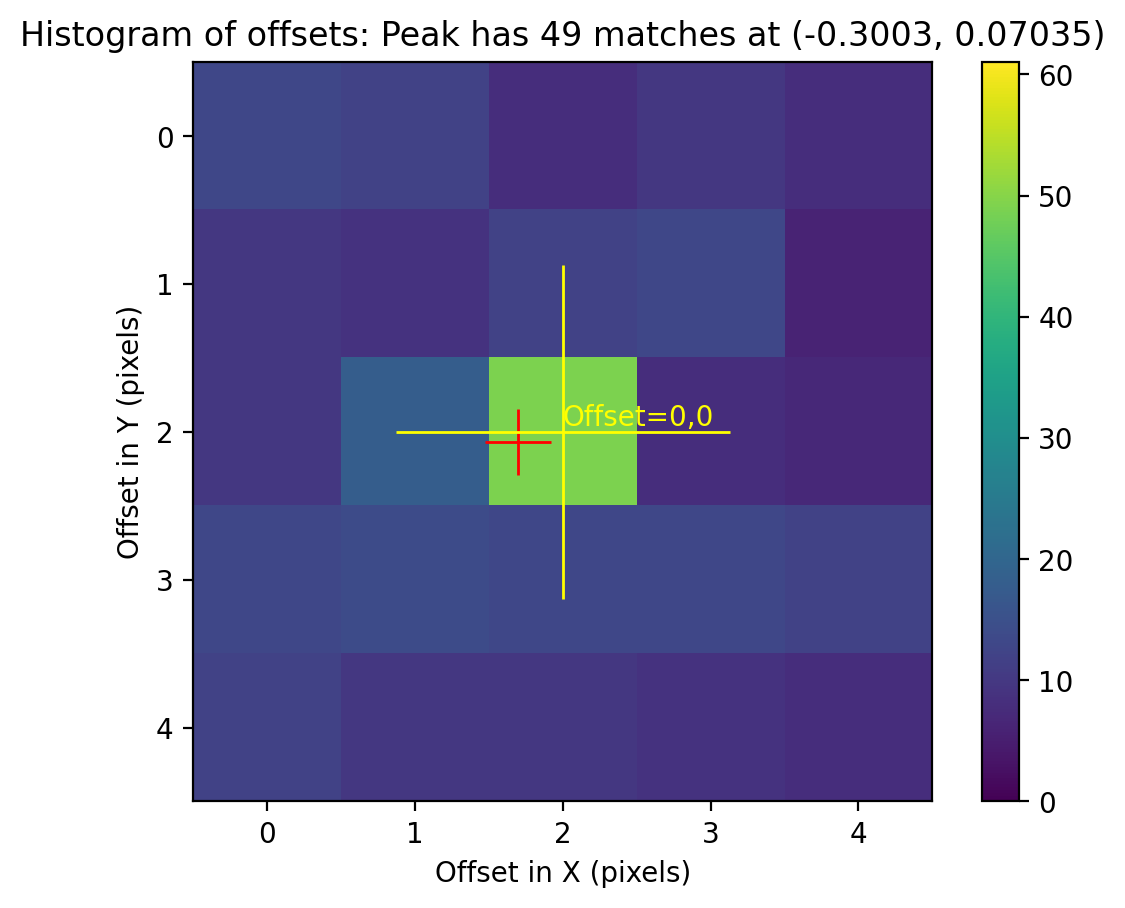

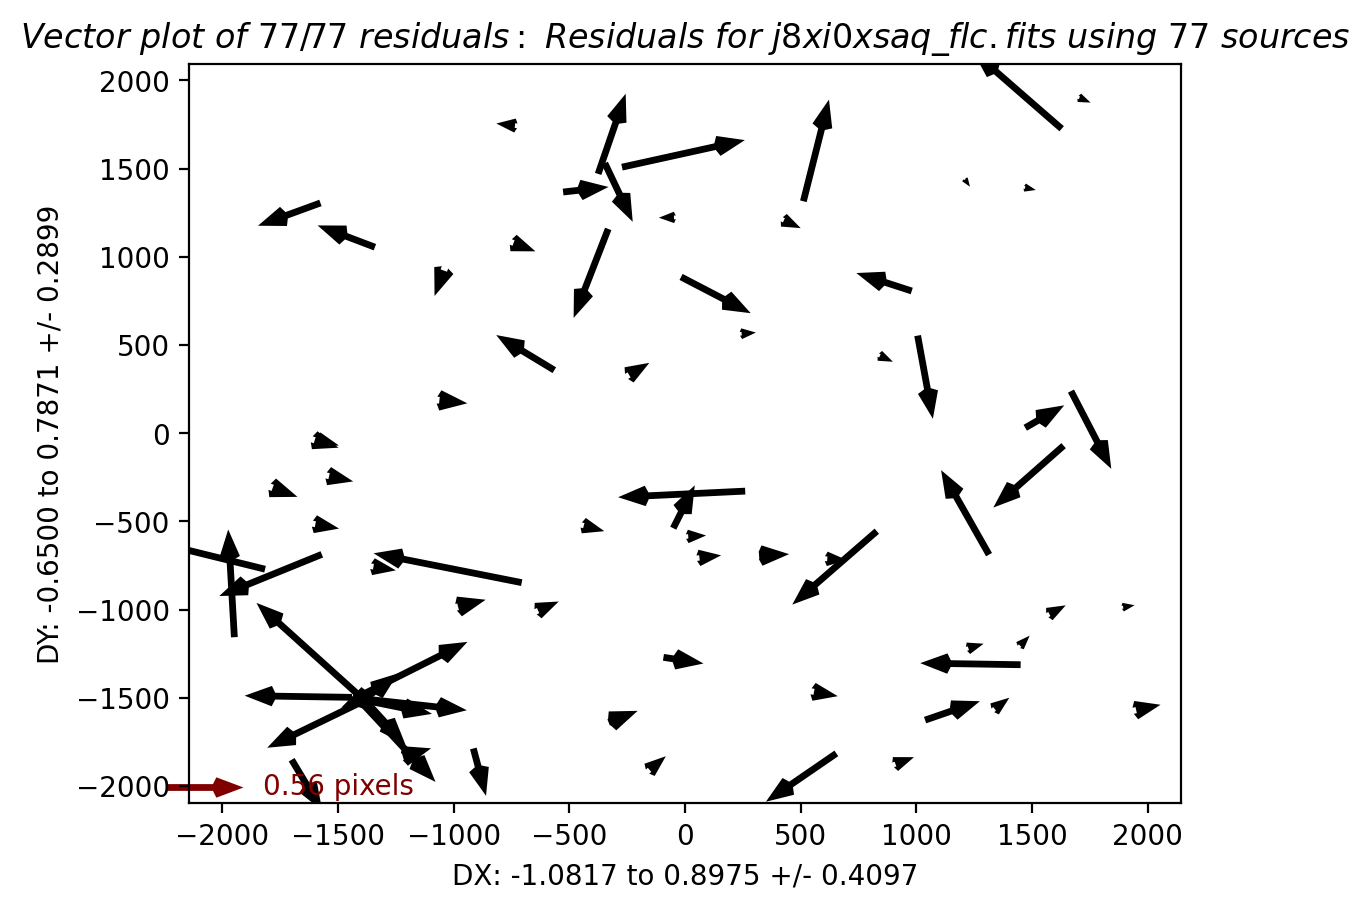

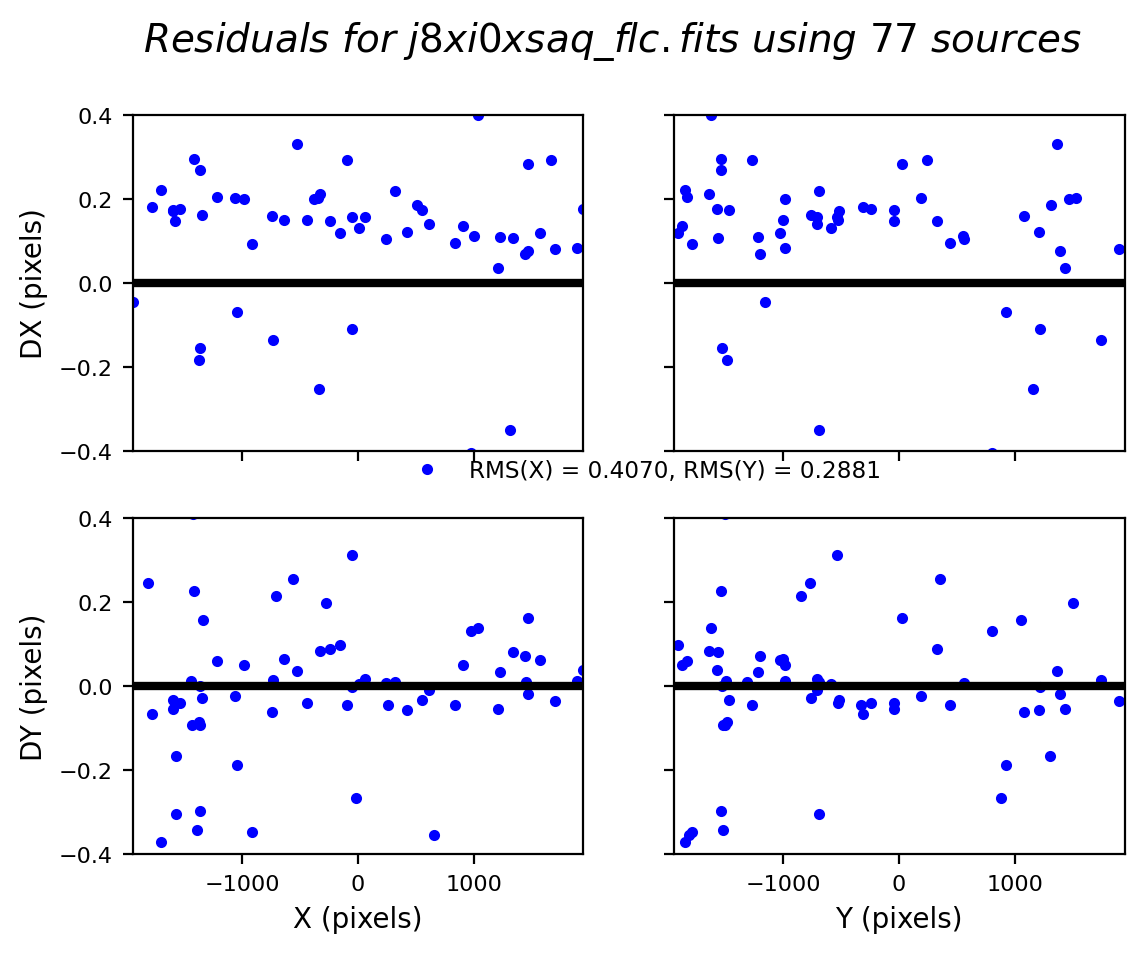

In [7]:
tweakreg.TweakReg(
    input_files,
    imagefindcfg={"threshold": 100, "conv_width": 3.5},
    shiftfile=True,
    outshifts="shift814_flc_test1.txt",
    updatehdr=False,
    interactive=False,
    ylimit=0.4,
    searchrad=0.1,
)
clear_output()

In [8]:
# If the alignment is unsuccessful, stop the notebook
with open("shift814_flc_test1.txt", "r") as shift:
    for line_number, line in enumerate(shift, start=1):
        if "nan" in line:
            raise ValueError("nan found in line {} in shift file".format(line_number))
        else:
            continue

In [9]:
# Inspect the shift file for Test 1
shift_table = Table.read(
    "shift814_flc_test1.txt",
    format="ascii.no_header",
    names=["file", "dx", "dy", "rot", "scale", "xrms", "yrms"],
)
formats = [".2f", ".2f", ".3f", ".5f", ".2f", ".2f"]
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=4>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
j8xi0xs0q_flc.fits    0.00    0.00   0.000 1.00000    0.00    0.00
j8xi0xs3q_flc.fits    0.10    0.00   0.002 0.99998    0.35    0.22
j8xi0xs6q_flc.fits    0.07    0.05 360.000 1.00002    0.42    0.32
j8xi0xsaq_flc.fits   -0.21   -0.13 360.000 1.00001    0.41    0.29

To verify that `TweakReg` has found a good fit, it is important to look at the shift file and the fit residuals. 

Below are the dx,dy residuals for each FLC file with respect to the reference image `j8xi0xsaq_flc.fits`. 

`TweakReg` finds ~75 matches per frame, but the RMS of the fit residuals is large at ~0.3 pixels, and the points are not nicely clustered around dx,dy=0.0, as expected for a good fit.

In [10]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs:
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, "test1_{}".format(png)))
    os.rename(path, new_path)

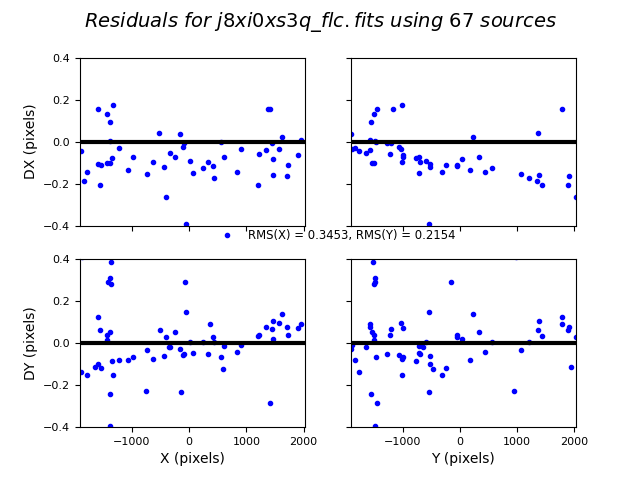

In [11]:
Image(filename="test1_residuals_j8xi0xs3q_flc.png")

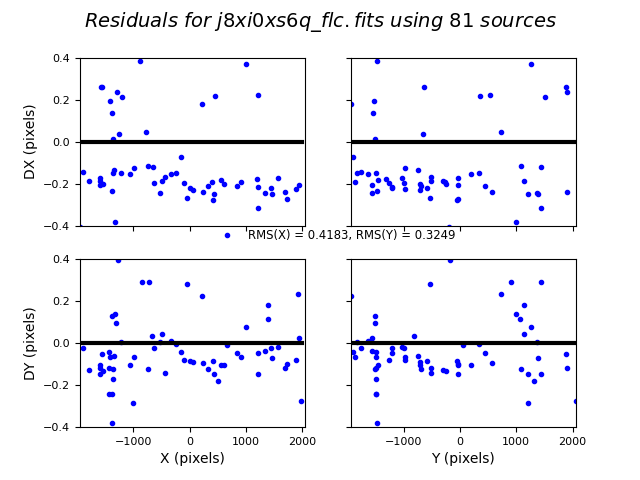

In [12]:
Image(filename="test1_residuals_j8xi0xs6q_flc.png")

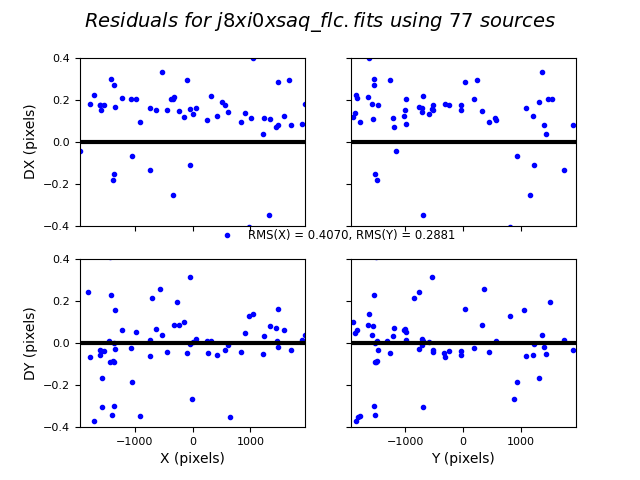

In [13]:
Image(filename="test1_residuals_j8xi0xsaq_flc.png")

### 2.2 Adjust `conv_width` to find extended objects (Test 2) <a id="test2"></a>

In order for `TweakReg` to use compact galaxies rather than point sources for alignment, we increase the convolution kernel width parameter `conv_width` from 3.5 to 6.0 pixels in order to find sources with a FWHM ~3 pixels in the FLC frames.

In [14]:
tweakreg.TweakReg(
    input_files,
    imagefindcfg={"threshold": 100, "conv_width": 6.0},
    shiftfile=True,
    outshifts="shift814_flc_test2.txt",
    updatehdr=False,
    interactive=False,
    ylimit=0.4,
    searchrad=0.1,
)
clear_output()

In [15]:
# Inspect the shift file for Test2
shift_table2 = Table.read(
    "shift814_flc_test2.txt",
    format="ascii.no_header",
    names=["file", "dx", "dy", "rot", "scale", "xrms", "yrms"],
)
formats = [".2f", ".2f", ".3f", ".5f", ".2f", ".2f"]
for i, col in enumerate(shift_table2.colnames[1:]):
    shift_table2[col].format = formats[i]
shift_table2

<Table length=4>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
j8xi0xs0q_flc.fits    0.00    0.00   0.000 1.00000    0.00    0.00
j8xi0xs3q_flc.fits   -0.01   -0.01 360.000 1.00000    0.06    0.11
j8xi0xs6q_flc.fits   -0.08   -0.07 359.999 1.00000    0.18    0.09
j8xi0xsaq_flc.fits   -0.07   -0.15 359.999 1.00000    0.09    0.10

`TweakReg` now matches ~40 objects per frame, and the fit for images 2 and 4 look good, with an RMS ~0.1 pixels and with the residuals dx,dy clustered around 0.0.  For the third image `j8xi0xs6q_flc.fits`, the XRMS is ~0.2 pixels, and the points are not centered around dx,dy=0 pixels.

In [16]:
# Give the 'fit residual plots' a unique name for comparison with subsequent tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs:
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, "test2_{}".format(png)))
    os.rename(path, new_path)

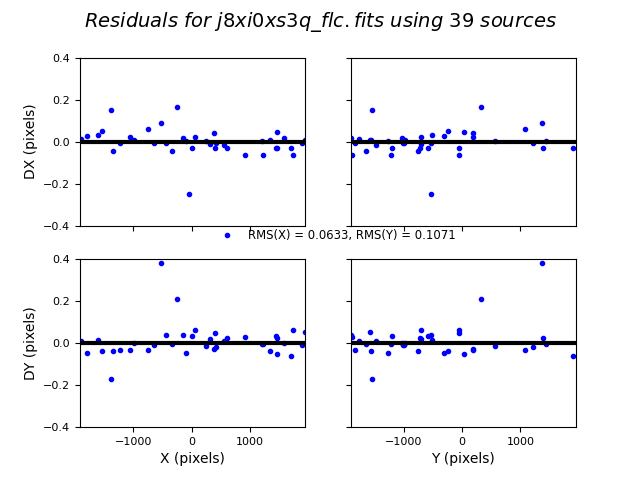

In [17]:
Image(filename="test2_residuals_j8xi0xs3q_flc.png")

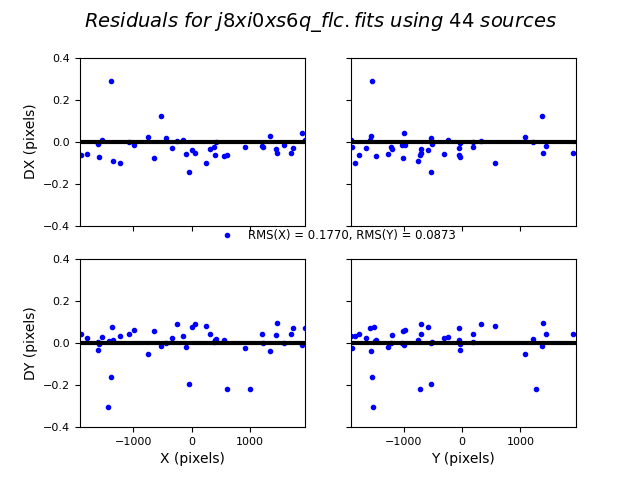

In [18]:
Image(filename="test2_residuals_j8xi0xs6q_flc.png")

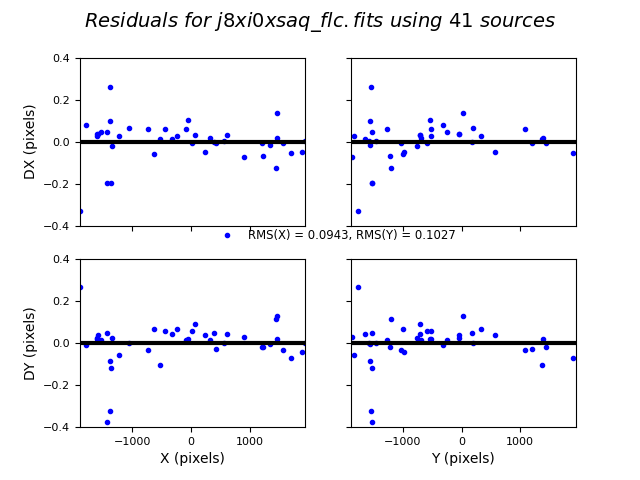

In [19]:
Image(filename="test2_residuals_j8xi0xsaq_flc.png")

### 2.3 Exclude flagged pixels with `dqbits` (Test 3) <a id="test3"></a>

To further improve the alignment, we make use of flags in the DQ array of the FLC files. The source finding parameters in `TweakReg` may be modified to exclude flagged pixels when generating lists of objects in each image.

Setting the parameter `dqbits=0` will consider all non-zero pixels in the DQ mask to be “bad” pixels, and the corresponding image pixels will not be used for source finding. The default value of `None` will turn off the use of image’s DQ array for source finding. 

In this case, `AstroDrizzle` was already run by MAST on visit 0X, and cosmic-ray flags were populated in the DQ array of the FLC frames. Since the exposures within this visit were already well aligned, the 4096 flags for cosmic rays are useful for excluding false detections.

Detailed definitions of the ACS DQ flags can be found at [this webpage.](https://www.stsci.edu/hst/instrumentation/acs/data-analysis/dq-flag-definitions)

In [20]:
tweakreg.TweakReg(
    input_files,
    imagefindcfg={"threshold": 100, "conv_width": 6.0, "dqbits": 0},
    shiftfile=True,
    outshifts="shift814_flc_test3.txt",
    updatehdr=False,
    interactive=False,
    ylimit=0.4,
    searchrad=0.1,
)
clear_output()

In [21]:
# Inspect the shift file for Test2
shift_table3 = Table.read(
    "shift814_flc_test3.txt",
    format="ascii.no_header",
    names=["file", "dx", "dy", "rot", "scale", "xrms", "yrms"],
)
formats = [".2f", ".2f", ".3f", ".5f", ".2f", ".2f"]
for i, col in enumerate(shift_table3.colnames[1:]):
    shift_table3[col].format = formats[i]
shift_table3

<Table length=4>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
j8xi0xs0q_flc.fits    0.00    0.00   0.000 1.00000    0.00    0.00
j8xi0xs3q_flc.fits   -0.01   -0.02 359.999 0.99999    0.04    0.04
j8xi0xs6q_flc.fits   -0.12   -0.04 359.999 1.00000    0.03    0.03
j8xi0xsaq_flc.fits   -0.08   -0.13 359.999 1.00000    0.11    0.08

In this third test, `TweakReg` again finds ~40 matches per frame, but with spurious detections eliminated has an easier time locking onto the correct solution.  The fit residuals below all have an RMS ~0.1 pixels and the points are all clustered around dx,dy=0.

In [22]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs:
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, "test3_{}".format(png)))
    os.rename(path, new_path)

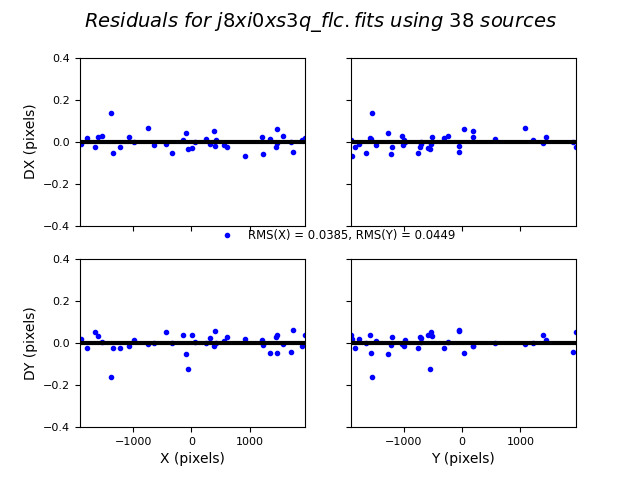

In [23]:
Image(filename="test3_residuals_j8xi0xs3q_flc.png")

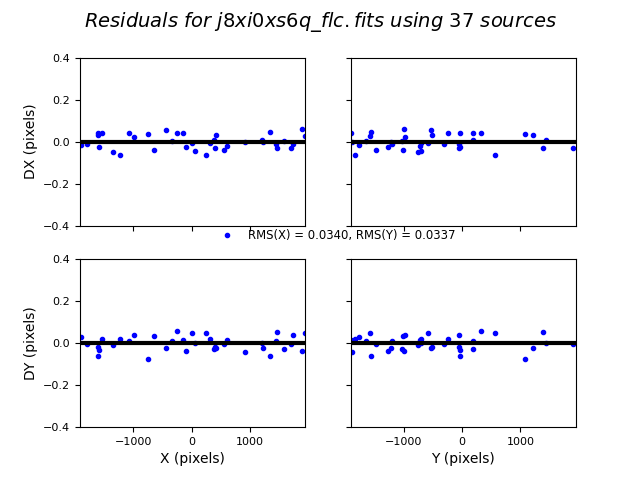

In [24]:
Image(filename="test3_residuals_j8xi0xs6q_flc.png")

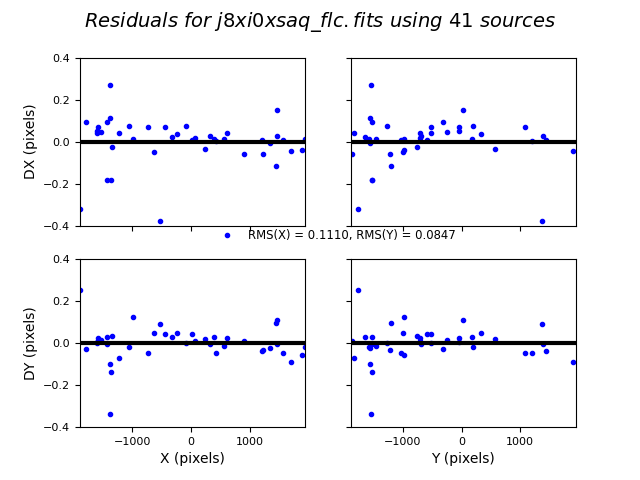

In [25]:
Image(filename="test3_residuals_j8xi0xsaq_flc.png")

Here we compare the accuracy of the `TweakReg` solution with the MAST alignment results.  

First, we print the number of matches per image and compare with MAST WCS fitting results. Note that MAST finds a larger number of matches but also has a much larger fit RMS ~0.8 pixels. 

In [26]:
match_files = glob.glob('*_flc_catalog_fit.match')
for f in match_files:
    input = ascii.read(f)
    print('Number of Matches for', f, ' = ', len(input))

Number of Matches for j8xi0xs3q_flc_catalog_fit.match  =  38
Number of Matches for j8xi0xsaq_flc_catalog_fit.match  =  41
Number of Matches for j8xi0xs6q_flc_catalog_fit.match  =  37


In [27]:
wcstable

<Table length=4>
     filename      DETECTOR EXPTIME ... RMS_DEC RMS_RA_pix RMS_DEC_pix
      str18          str3   float64 ... float64  float64     float64  
------------------ -------- ------- ... ------- ---------- -----------
j8xi0xs0q_flc.fits      WFC   507.0 ...    41.9       0.77        0.84
j8xi0xs3q_flc.fits      WFC   507.0 ...    41.9       0.77        0.84
j8xi0xs6q_flc.fits      WFC   507.0 ...    41.9       0.77        0.84
j8xi0xsaq_flc.fits      WFC   507.0 ...    41.9       0.77        0.84

In [28]:
shift_table3

<Table length=4>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
j8xi0xs0q_flc.fits    0.00    0.00   0.000 1.00000    0.00    0.00
j8xi0xs3q_flc.fits   -0.01   -0.02 359.999 0.99999    0.04    0.04
j8xi0xs6q_flc.fits   -0.12   -0.04 359.999 1.00000    0.03    0.03
j8xi0xsaq_flc.fits   -0.08   -0.13 359.999 1.00000    0.11    0.08

These results show that the images with large dithers have small pointing errors ~0.1 pixels which will need to be corrected before recombining the FLC frames.  Before doing that, we do one last quality check to verify that the matched sources used for the fit correspond to real astronomical sources and not image artifacts. 

### 2.4 Overplot Matched Sources on the Image <a id="overplot"></a>

Let's plot the sources that were matched between two FLC frames. 

The cell below shows how to read in the `*_fit.match` file as an `astropy` table. Unfortunately, it doesn't automatically name columns so you'll have to look at the header to grab the columns.

To verify that `TweakReg` obtained a good fit between matched source catalogs, it is useful to inspect the results before updating the image header WCS. Below sources matched with Gaia are overplotted on one of the input FLC frames (with the two chips merged together). 

It can be useful to check that `TweakReg` locked onto stars and not hot pixels or other detector artifacts before proceeding to update the image header. 

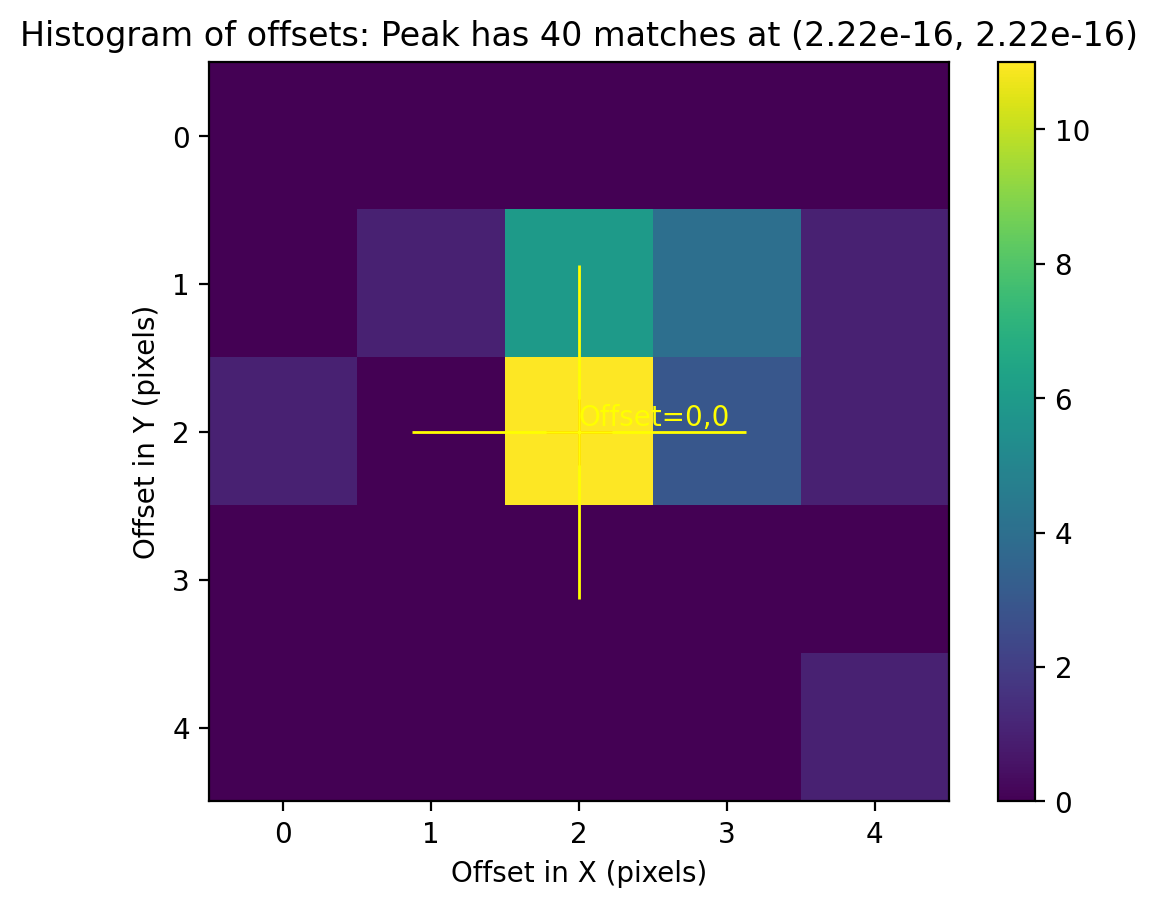

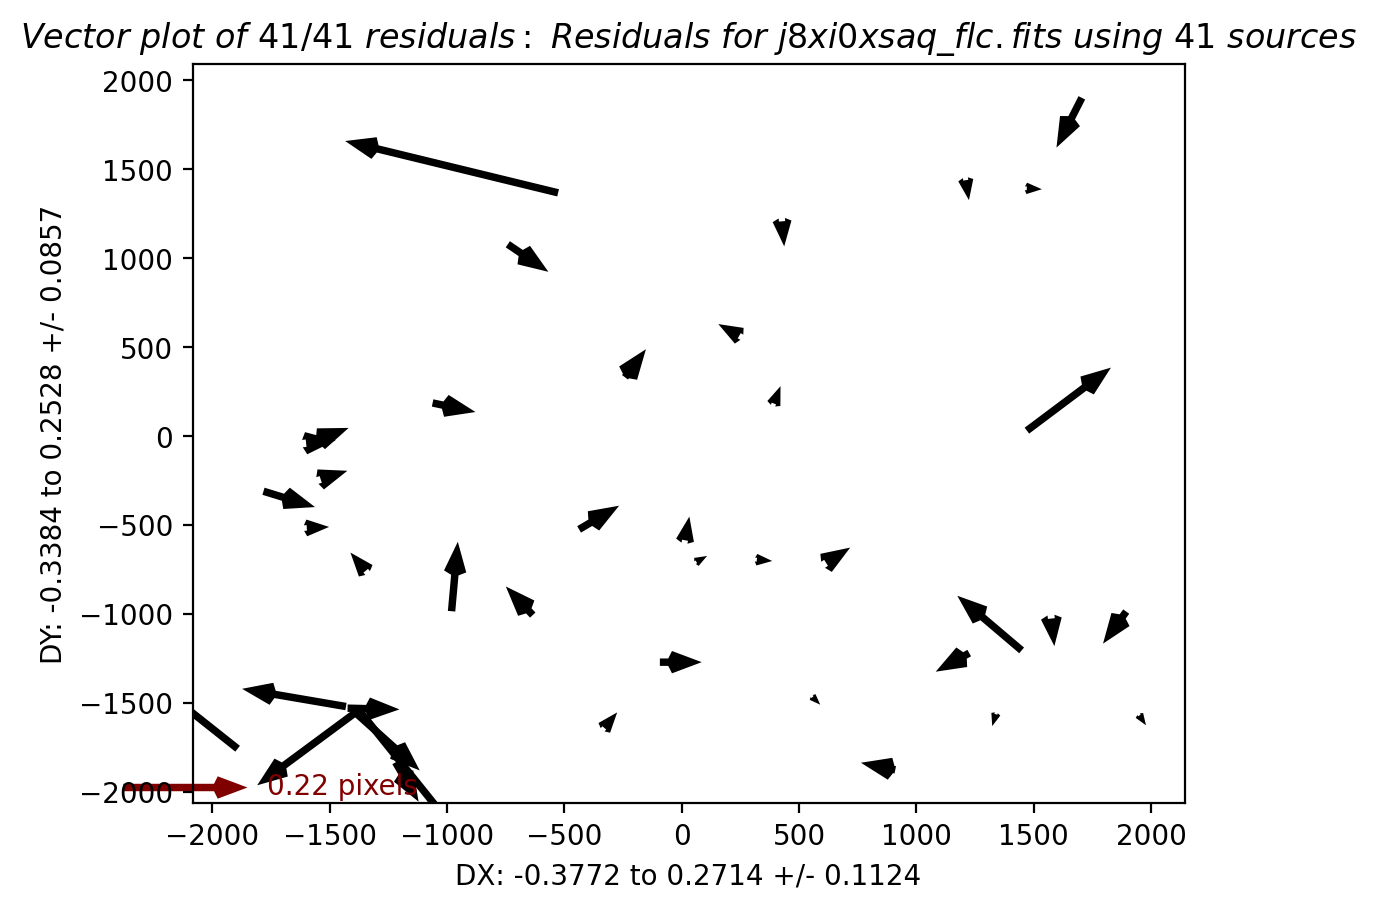

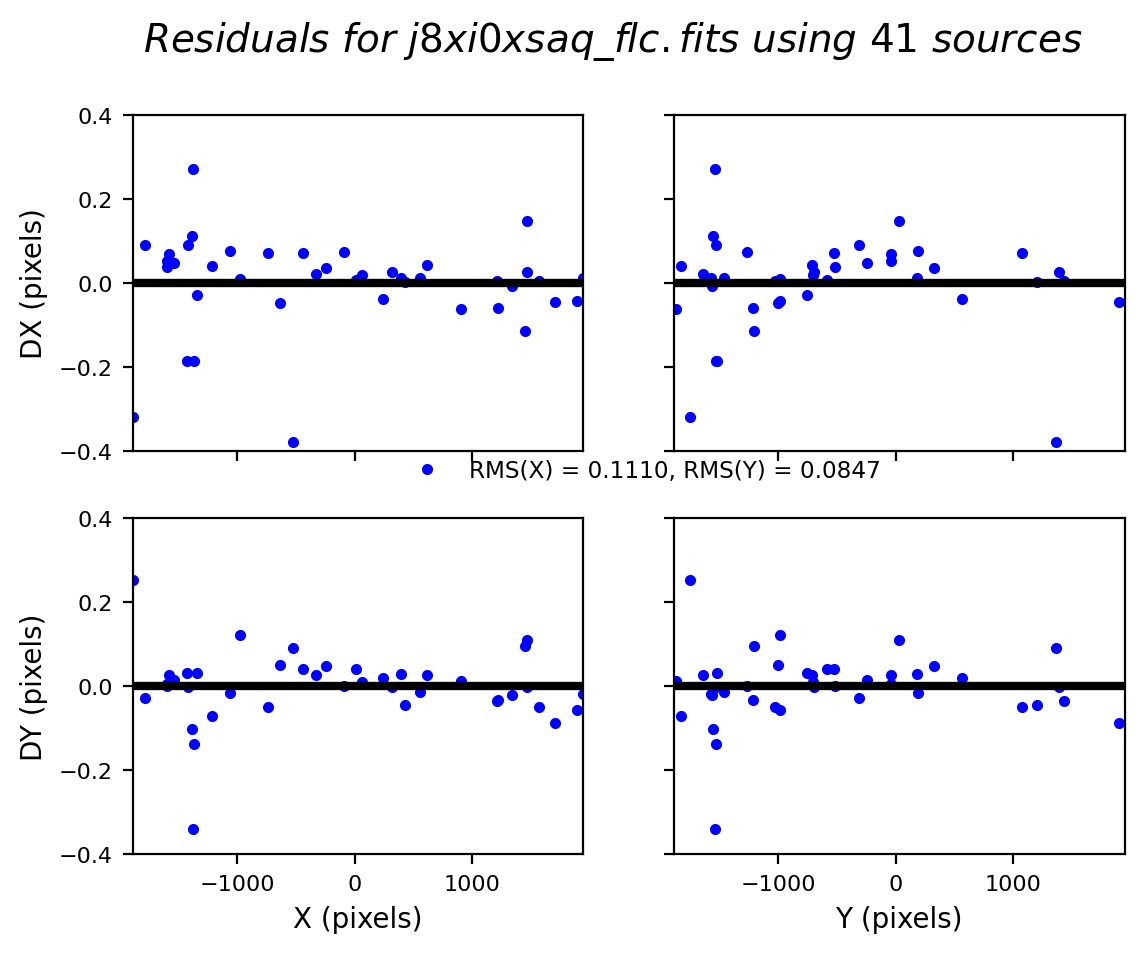

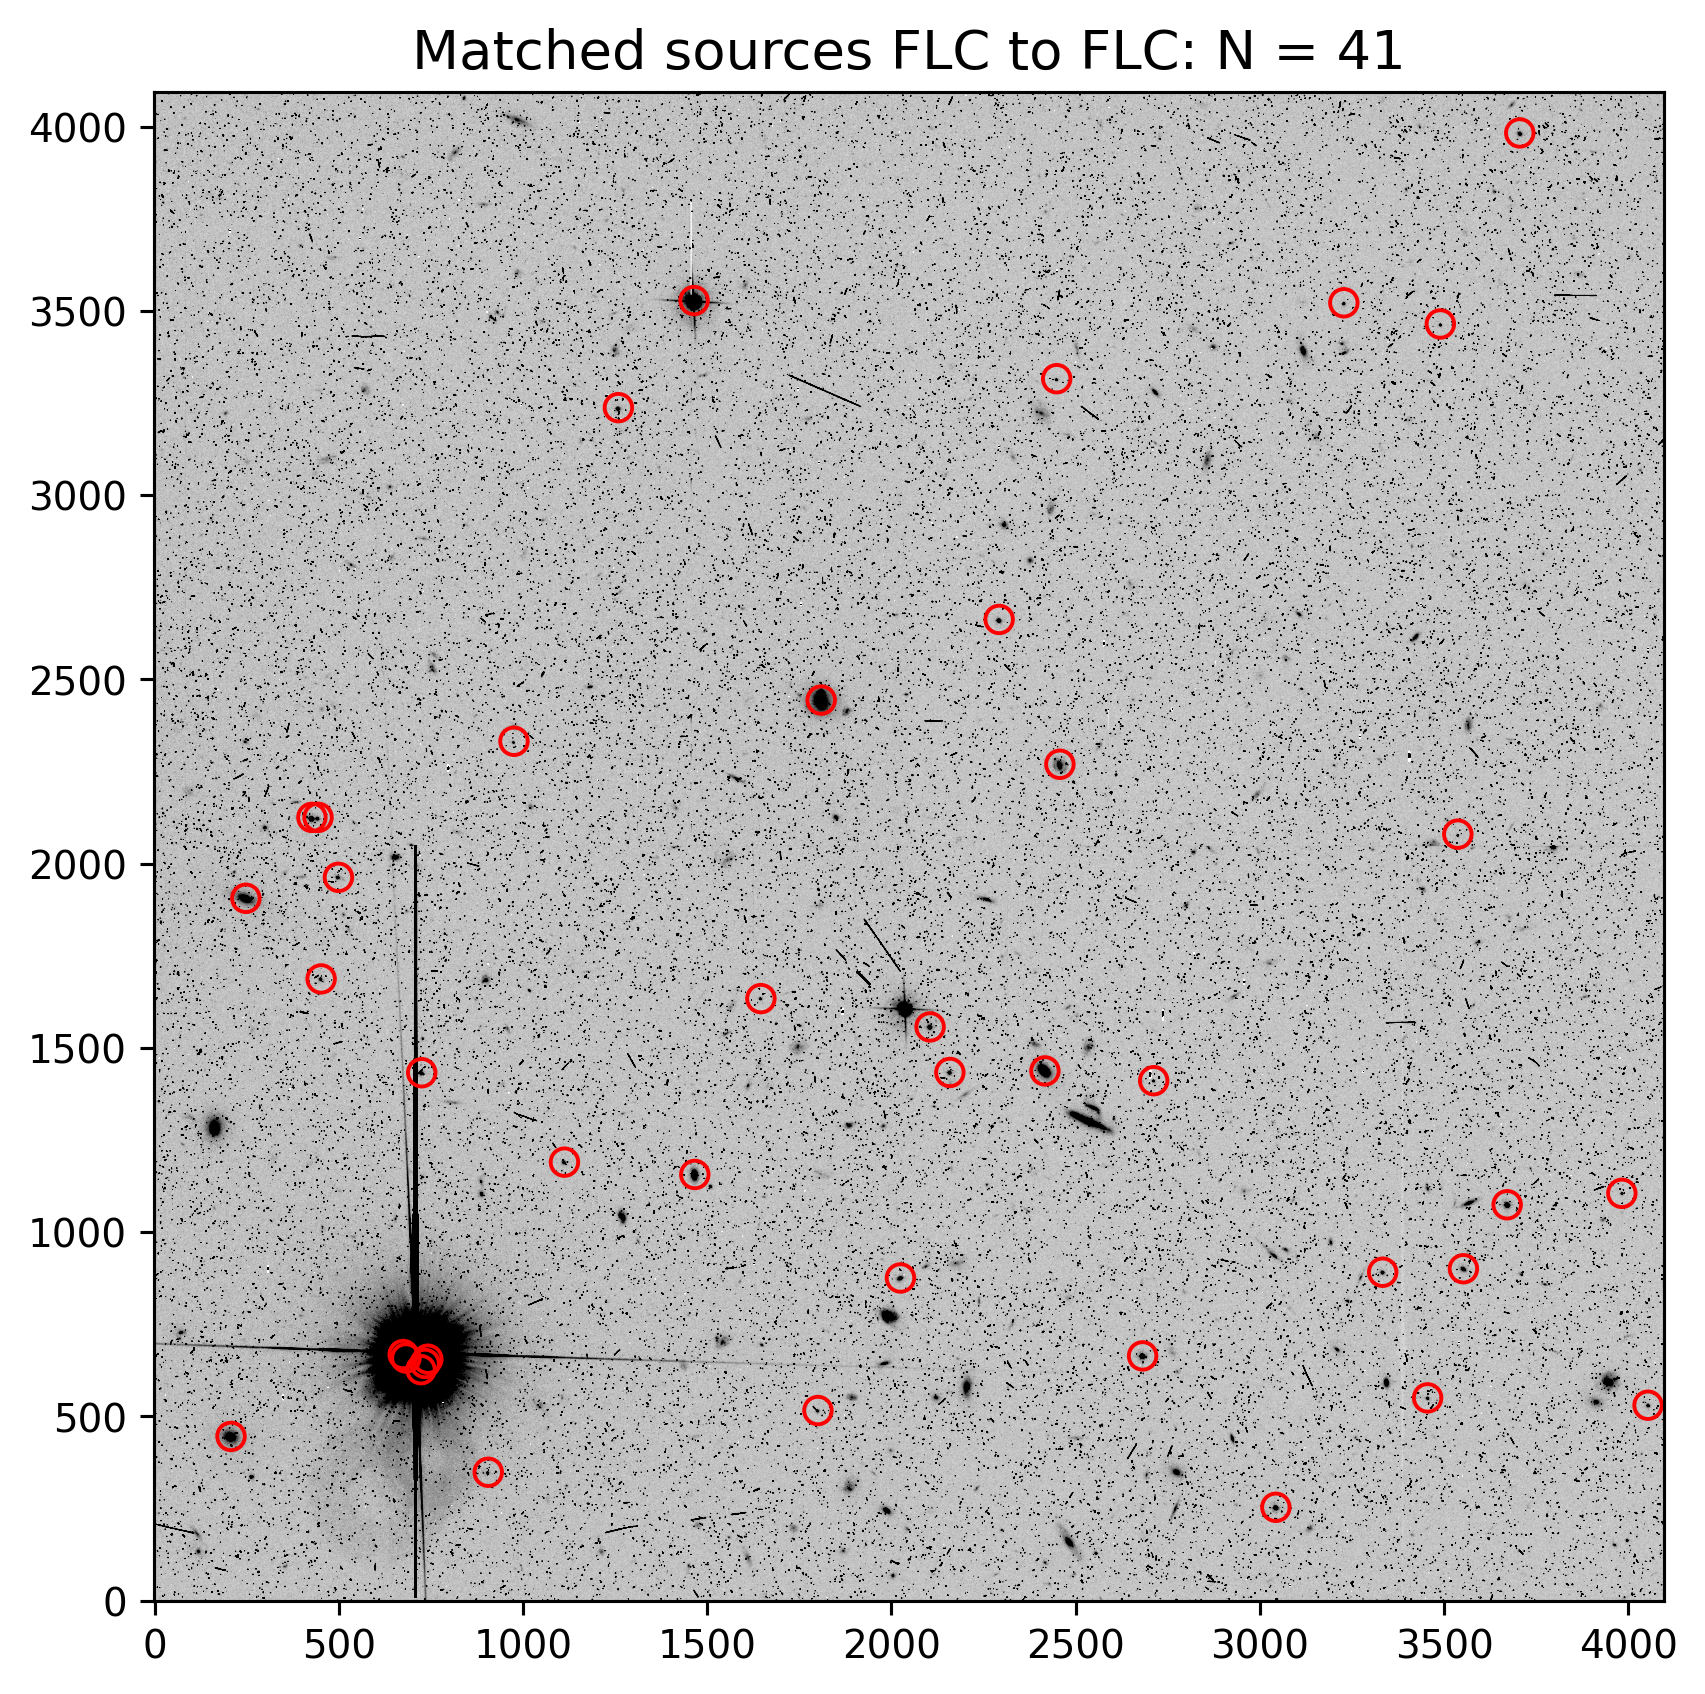

In [29]:
rootname = "j8xi0xsaq"

plt.figure(figsize=(7, 7), dpi=140)
chip1_data = fits.getdata(rootname + "_flc.fits", "SCI", 2)
chip2_data = fits.getdata(rootname + "_flc.fits", "SCI", 1)
fullsci = np.concatenate([chip2_data, chip1_data])
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(fullsci)
plt.imshow(fullsci, cmap="Greys", origin="lower", vmin=z1, vmax=z2)

match_tab = ascii.read(
    rootname + "_flc_catalog_fit.match"
)  # load match file in astropy table
match_tab_chip1 = match_tab[
    match_tab["col15"] == 2
]  # filter table for sources on chip 1 (on ext 4)
match_tab_chip2 = match_tab[
    match_tab["col15"] == 1
]  # filter table for sources on chip 1 (on ext 4)
x_cord1, y_cord1 = match_tab_chip1["col11"], match_tab_chip1["col12"]
x_cord2, y_cord2 = match_tab_chip2["col11"], match_tab_chip2["col12"]

plt.scatter(
    x_cord1,
    y_cord1 + 2051,
    s=50,
    edgecolor="r",
    facecolor="None",
    label="Matched Sources",
)
plt.scatter(x_cord2, y_cord2, s=50, edgecolor="r", facecolor="None")
plt.title(f"Matched sources FLC to FLC: N = {len(match_tab)}", fontsize=14)
plt.show()

### 2.5 Rerun TweakReg to update the header WCS <a id="updatehdr"></a>

Now run that we are happy with the alignment, we run `TweakReg` a final time with `updatehdr=True` to update the image header WCS with the improved solution.

In [30]:
tweakreg.TweakReg(
    input_files,
    imagefindcfg={"threshold": 100, "conv_width": 6.0, "dqbits": 0},
    shiftfile=False,
    updatehdr=True,  # update the WCS
    interactive=False,
    ylimit=0.4,
    searchrad=0.1,
)
clear_output()

##  3. Combine the Images using `AstroDrizzle` <a id="adriz"></a>
[Table of Contents](#toc)

Finally, we combine the aligned FLC files with `AstroDrizzle`. Before starting, we get some recommended values for drizzling from the MDRIZTAB reference file.  The parameters in this file are different for each detector and are based on the number of input frames. These are a good starting point for drizzling and may be adjusted accordingly.

In [31]:
# The following lines of code find and download the MDRIZTAB reference file.
mdz = fits.getval(input_files[0], 'MDRIZTAB', ext=0).split('$')[1]
print('Searching for the MDRIZTAB file:', mdz)
get_mdriztab = os.system('crds sync --hst --files ' + mdz + ' --output-dir '+os.environ['jref'])

Searching for the MDRIZTAB file: 37g1550cj_mdz.fits


CRDS - INFO -  Symbolic context 'hst-operational' resolves to 'hst_1177.pmap'
CRDS - INFO -  Reorganizing 0 references from 'instrument' to 'flat'
CRDS - INFO -  Reorganizing from 'instrument' to 'flat' cache,  removing instrument directories.
CRDS - INFO -  Syncing explicitly listed files.
CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/37g1550cj_mdz.fits       247.7 K bytes  (1 / 1 files) (0 / 247.7 K bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  5 infos


In [32]:
from drizzlepac.processInput import getMdriztabPars

In [33]:
def get_vals_from_mdriztab(
    input_files,
    kw_list=[
        "driz_sep_bits",
        "combine_type",
        "driz_cr_snr",
        "driz_cr_scale",
        "final_bits",
    ],
):
    """Get only selected parameters from. the MDRIZTAB"""
    mdriz_dict = getMdriztabPars(input_files)

    requested_params = {}

    print("Outputting the following parameters:")
    for k in kw_list:
        requested_params[k] = mdriz_dict[k]
        print(k, mdriz_dict[k])

    return requested_params

In [34]:
selected_params = get_vals_from_mdriztab(input_files)

- MDRIZTAB: AstroDrizzle parameters read from row 3.
Outputting the following parameters:
driz_sep_bits 336
combine_type median
driz_cr_snr 3.5 3.0
driz_cr_scale 1.5 1.2
final_bits 336


In [35]:
selected_params

{'driz_sep_bits': '336',
 'combine_type': 'median',
 'driz_cr_snr': '3.5 3.0',
 'driz_cr_scale': '1.5 1.2',
 'final_bits': '336'}

Note that the parameter final_bits= '336' is equivalent to `final_bits`= '256, 64, 16'.   

The ACS team now corrects for stable hot pixels (DQ flag=16) via the dark reference files, so these pixels can be considered 'good'. Full well saturated pixels (DQ flag=256) and warm pixels (DQ flag=64) may also be treated as good. More details on the recommended drizzle parameters for ACS may be found in [ISR 2017-02](https://ui.adsabs.harvard.edu/abs/2017acs..rept....2H/abstract).

Next we run `AstroDrizzle` to remove the sky, flag cosmic rays, and combine the image using the selected parameters.  Note that these may be further refined in the cell below by uncommenting the line in the example shown below.

In [36]:
# To override any of the above values:
# selected_params['driz_cr_snr']   = '4.0 3.5'

astrodrizzle.AstroDrizzle(
    input_files,
    output="f814w",
    **selected_params,
    preserve=False,
    clean=True,
    build=False,
    context=False,
    skymethod="match",
    runfile="f814w_driz.log"
)
clear_output()

## 4. Inspect the drizzled science and weight images  <a id="display"></a>
[Table of Contents](#toc)

Finally, we inspect the science and weight images and inspect their data quality.  An imprint of sources in the weight image may indicate an error with the alignment and subsequent cosmic-ray rejection. 

For more details on inspecting the drizzled products after reprocessing, see [Section 7.3 in the DrizzlePac Handbook](https://hst-docs.stsci.edu/drizzpac/chapter-7-data-quality-checks-and-trouble-shooting-problems/7-3-inspecting-drizzled-products-after-user-reprocessing)

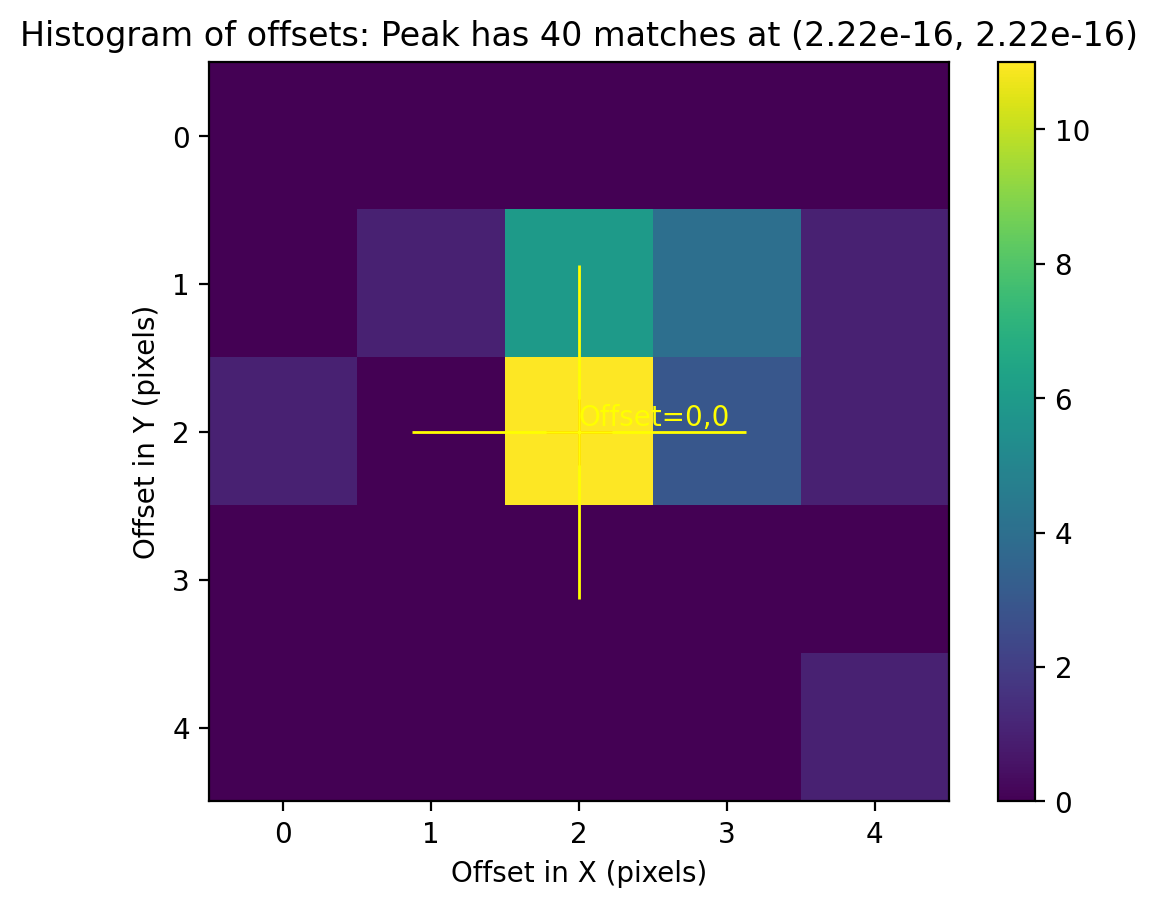

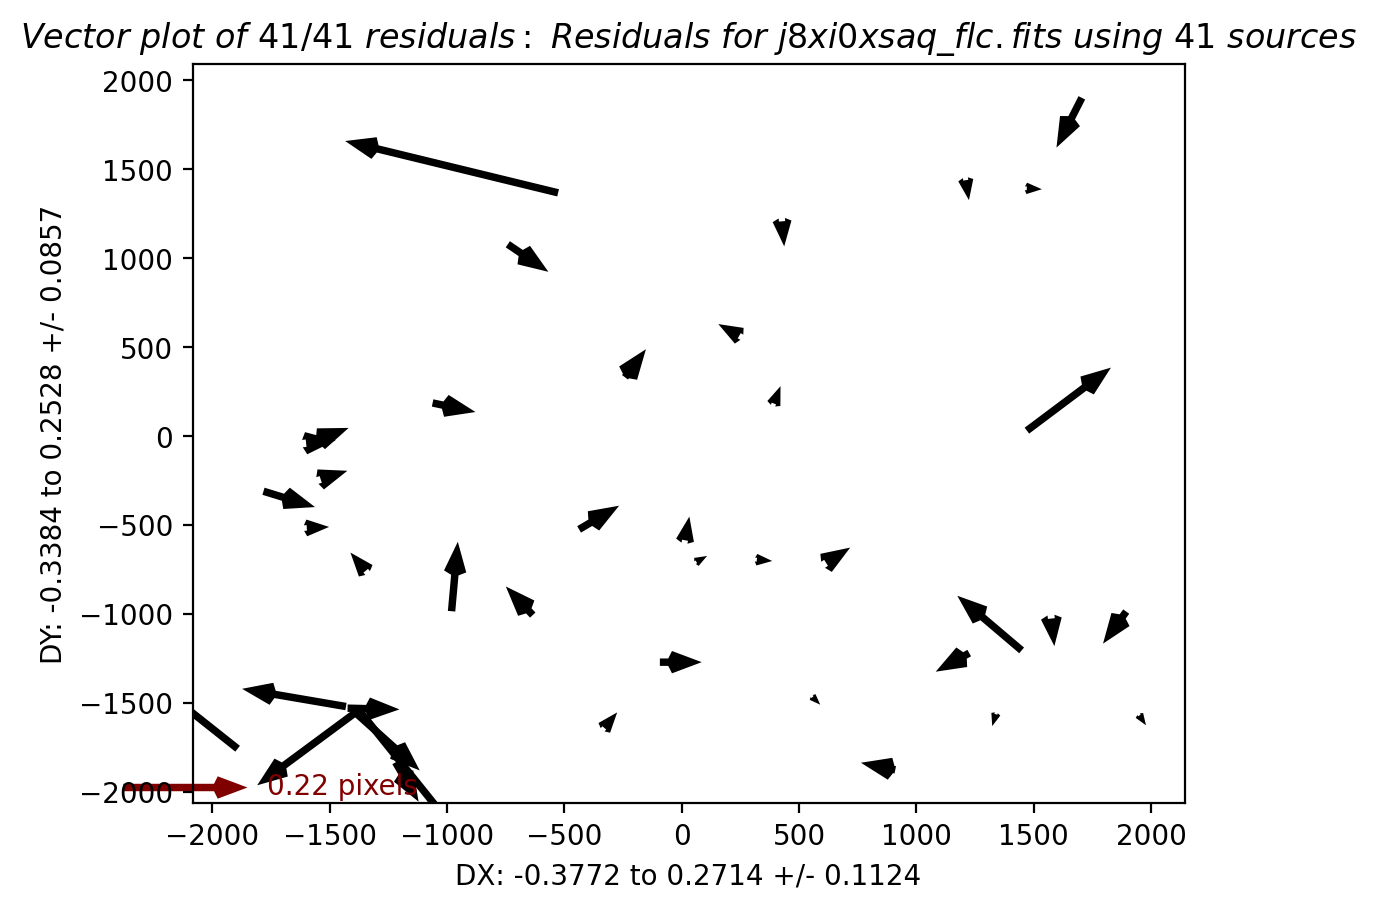

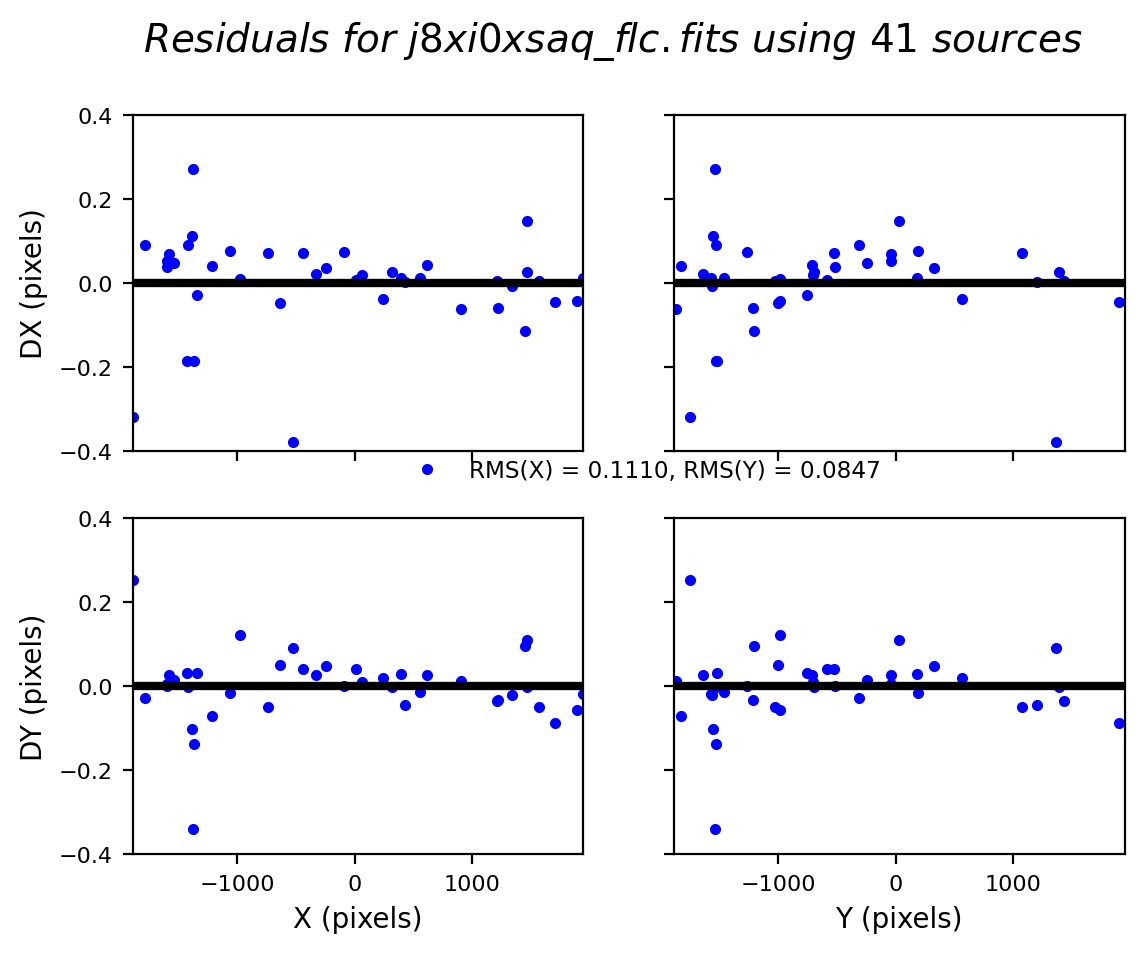

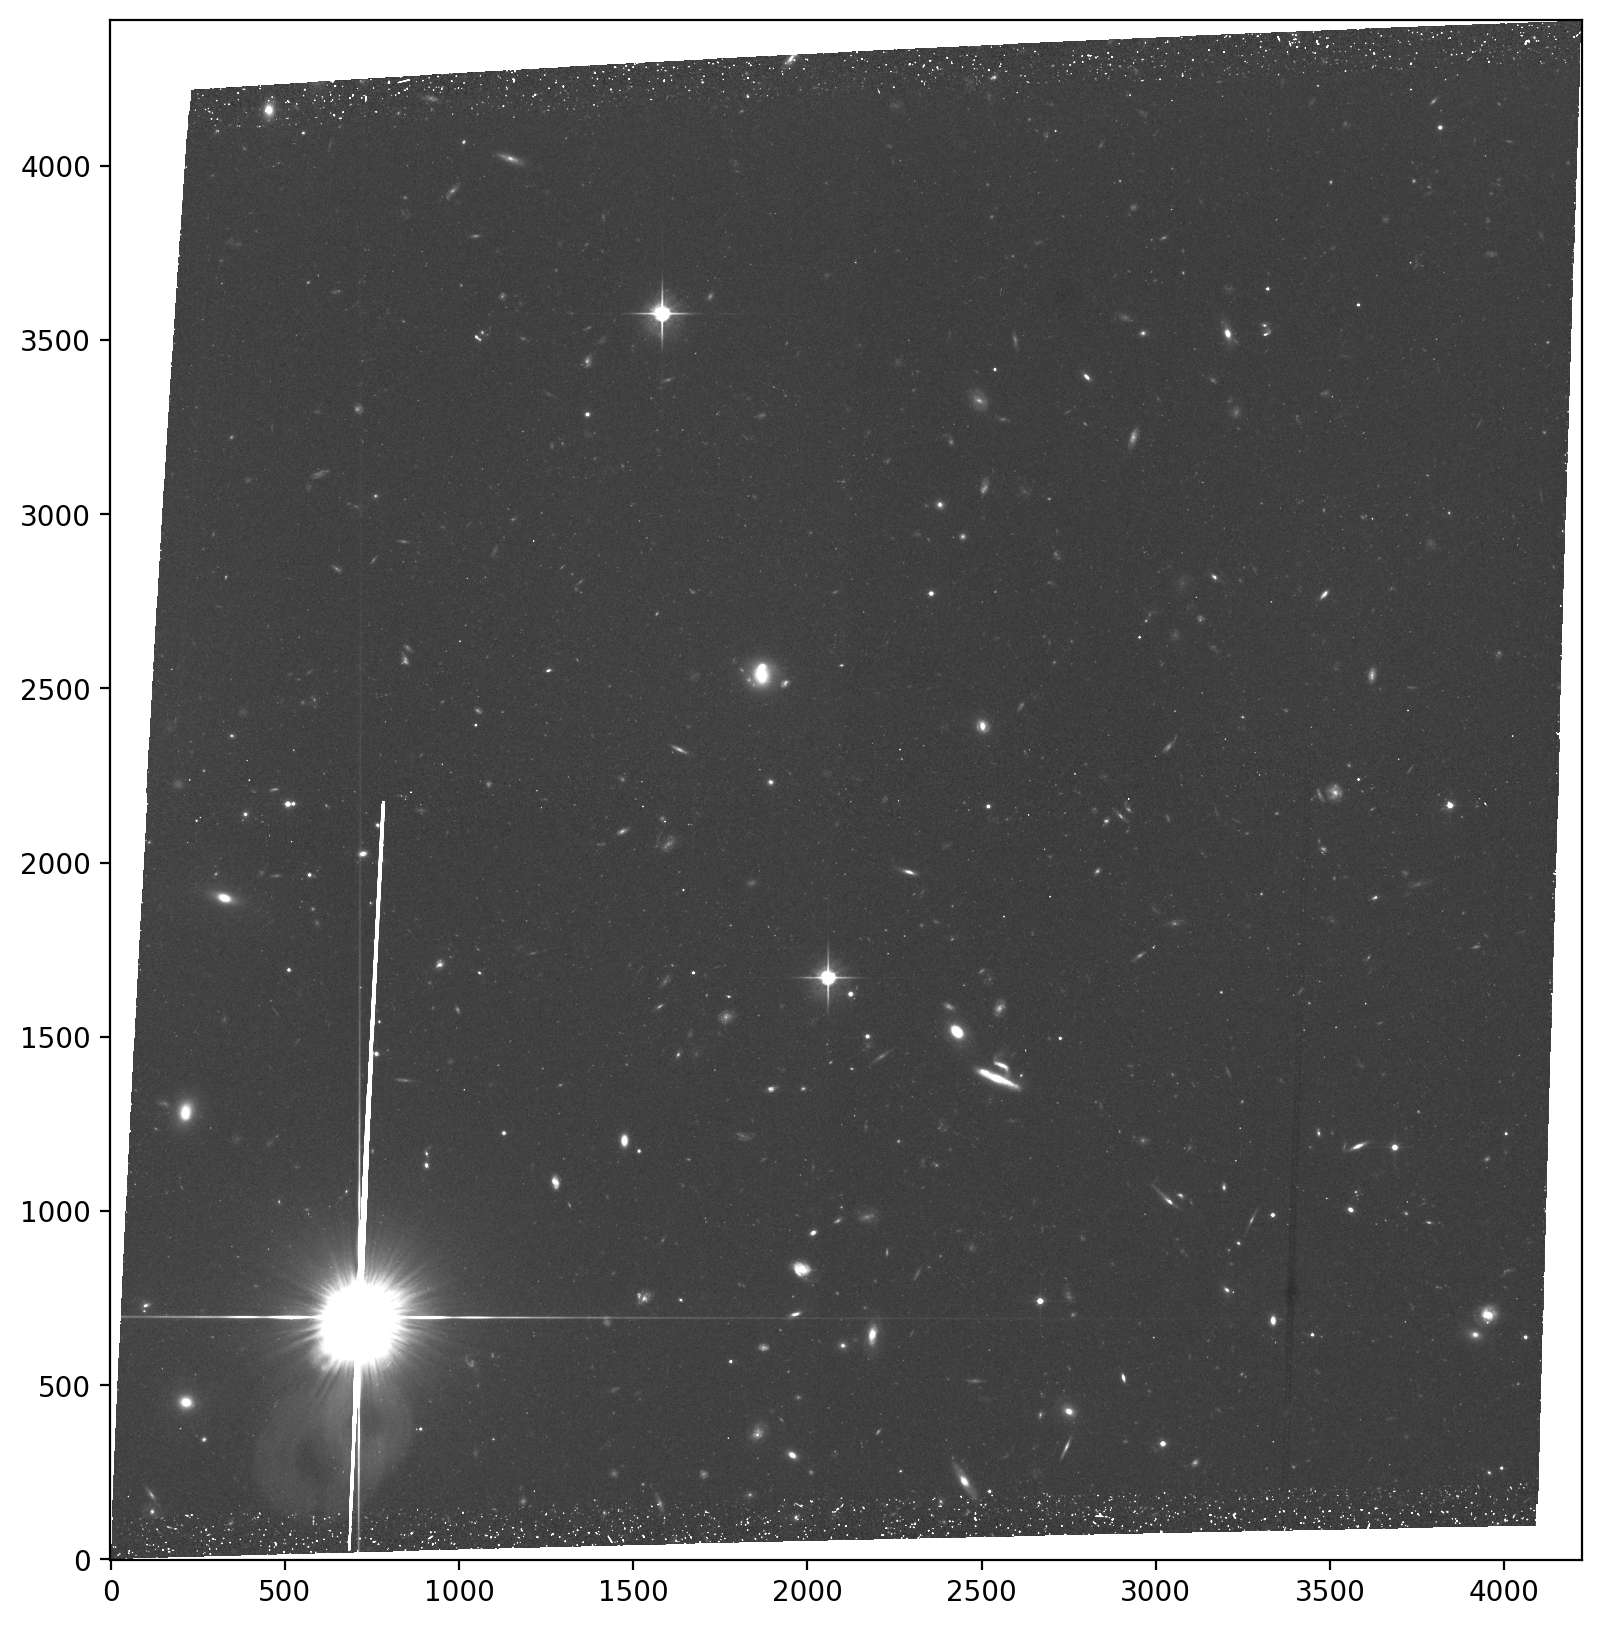

In [37]:
sci = fits.getdata("f814w_drc_sci.fits")
fig = plt.figure(figsize=(10, 10))
plt.imshow(sci, vmin=0.05, vmax=0.3, cmap="Greys_r", origin="lower")
plt.show()

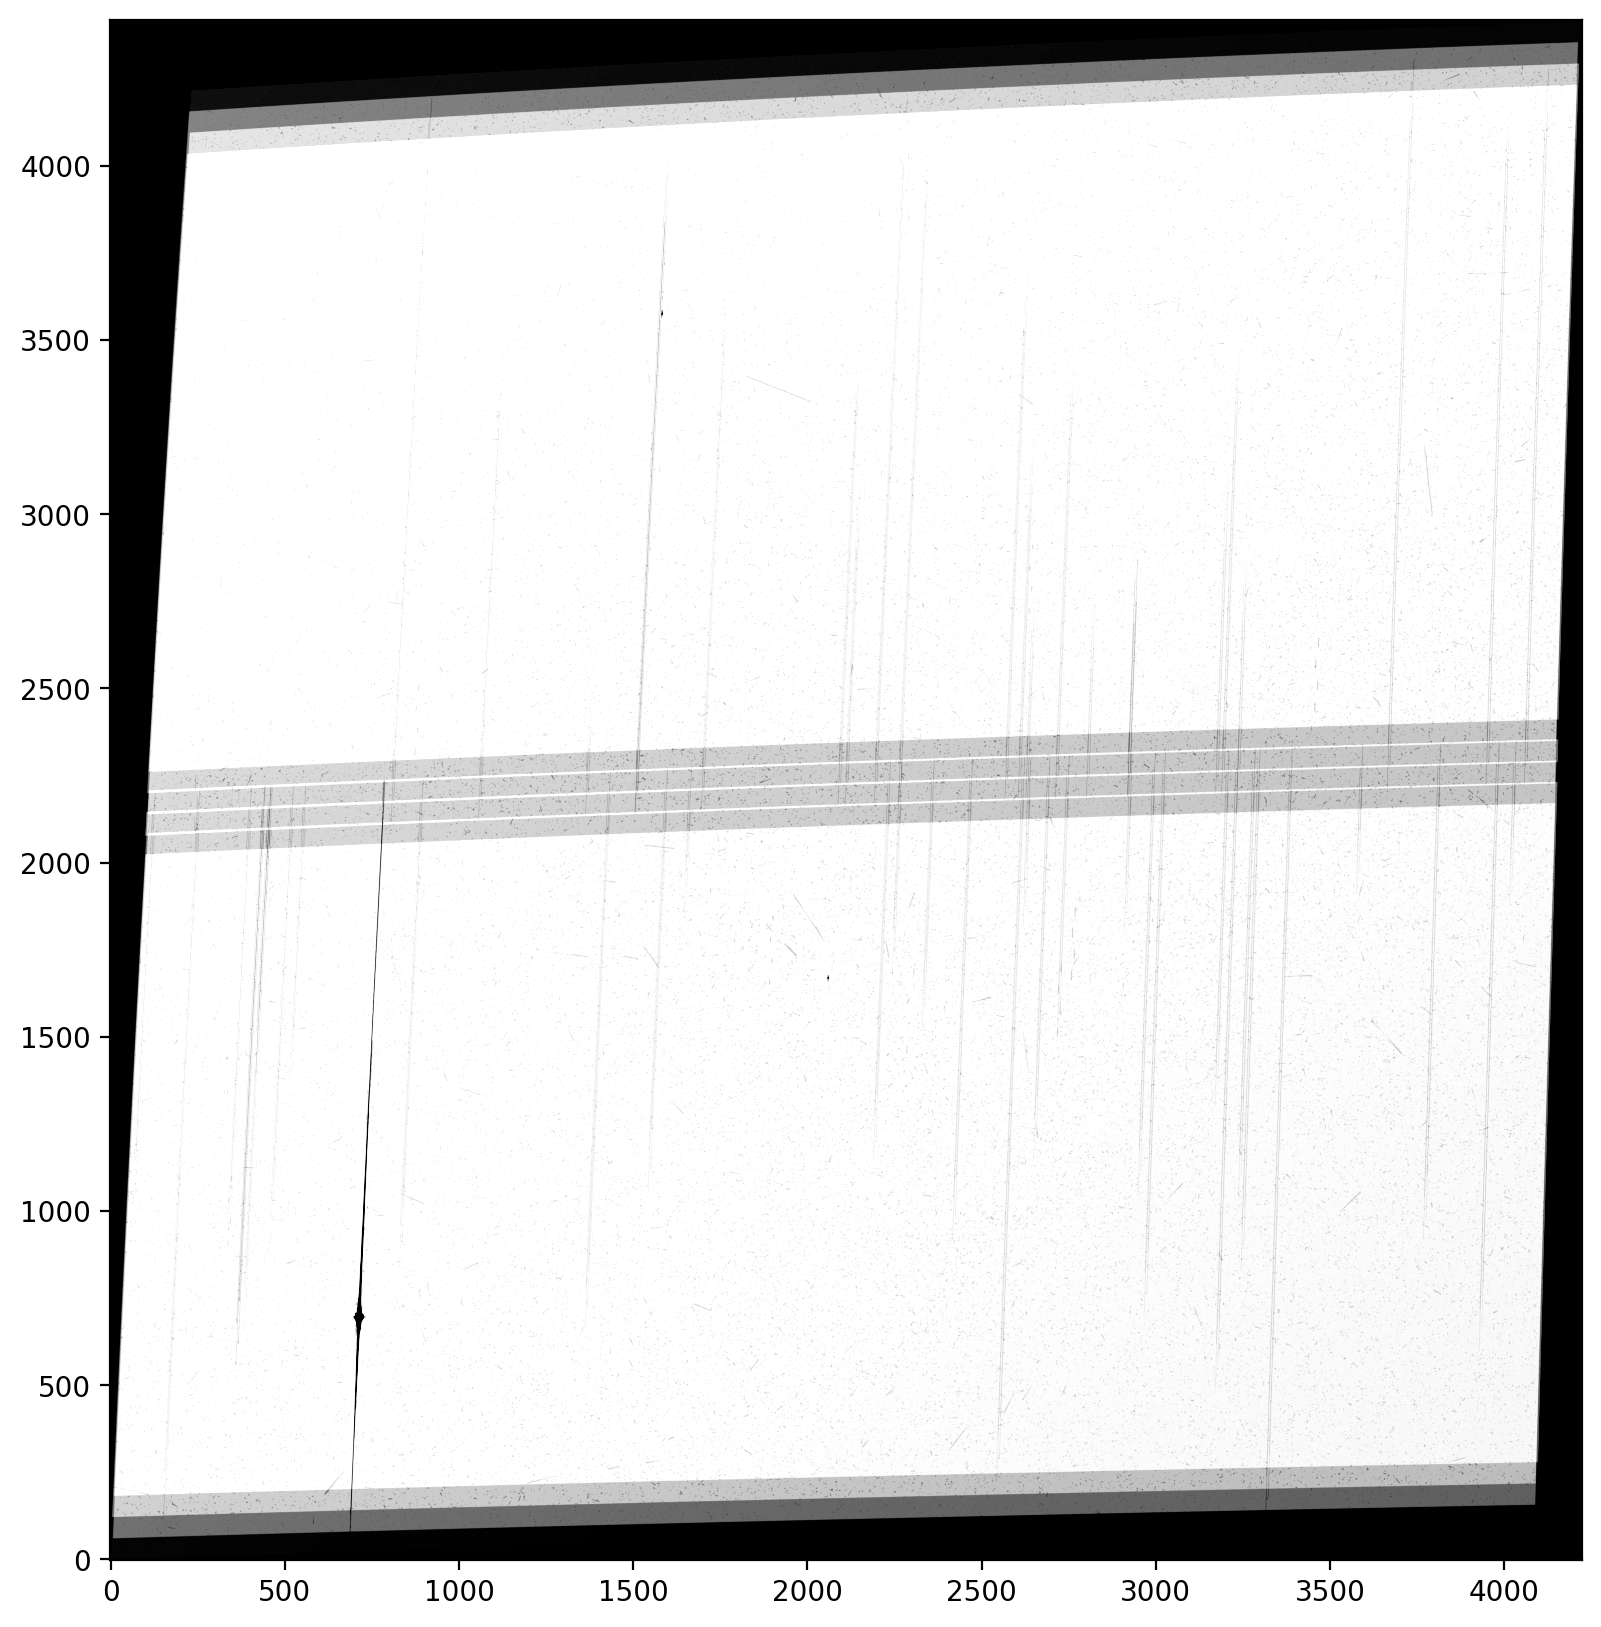

In [38]:
sci = fits.getdata("f814w_drc_wht.fits")
fig = plt.figure(figsize=(10, 10))
plt.imshow(sci, vmin=500, vmax=2000, cmap="Greys_r", origin="lower")
plt.show()

## Summary
[Table of Contents](#toc)

TweakReg may be used to align HST images based on the position of objects in the frame. Point sources are typically used for this purpose, but compact sources such as background galaxies may also be used by increasing the value of the parameter `conv_width` in `imagefindpars`. The data quality arrays of the input calibrated frames may also be used to further improve the fits by telling TweakReg to ignore pixels with specific flags inthe DQ array via the parameter `dqbits` in `imagefindpars`. 

## About this Notebook

    Created: 08 Jan 2019;     J. Mack
    Updated: 20 May 2024;     G. Anand, R. Avila, & J. Mack

**Source:** GitHub [spacetelescope/hst_notebooks](https://github.com/spacetelescope/hst_notebooks)

### Additional Resources <a id="add"></a>

Below are some additional resources that may be helpful. Please send questions through the [HST Help Desk](https://stsci.service-now.com/hst), selecting the DrizzlePac category.

- [ACS Website](https://www.stsci.edu/hst/instrumentation/acs)
- [ACS Instrument Handbook](https://hst-docs.stsci.edu/acsihb)
- [ACS Data Handbook](https://hst-docs.stsci.edu/acsdhb)

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)


### Citations <a id="cite"></a>
If you use Python packages such as `astropy`, `astroquery`, `drizzlepac`, `matplotlib`, or `numpy` for published research, please cite the authors. Follow these links for more information about citing various packages.

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `drizzlepac`](https://zenodo.org/records/3743274)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 